In [1]:
# Use this cell to regroup all your imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config; set_config(display='diagram')

# 🏆 Le Wagon Kaggle Batch Challenge

<img src='https://wagon-public-datasets.s3.amazonaws.com/data-science-images/ML/kaggle-batch-challenge.png' width=600>

🏆 Welcome to your first Kaggle competition!

Your objective is to **submit an answer online** to the open competition - [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

- Fortunately, you have already come across the house dataset in the bootcamp!
- You will be semi-guided up to a **baseline model**
- Only after will you be free to improve & refine your models
- We will approach the problem through **pipelines** (the best practice to take!)

A word on Kaggle:
- Kaggle will rank your submission amongst all participants!
- But don't worry, everyone is publicly removed from the leaderboard after 2 months
- You can make up to 10 submissions per day

🧹 Today is the perfect day to practice keeping your long notebook **tidy** 🧹
- "Collapse all headings" from the "command palette" (`Cmd + Shift + P`)
- Stay idempotent (`Restart & Run All` should never crash)
- Name and delete variables carefully

# Setup Kaggle

👉 Create an account on Kaggle if you want to participate in the competition. 

👉 Join the [House Prices Challenge](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) 

👉 Write down your Kaggle `username` in the [result spreadsheet here](https://docs.google.com/spreadsheets/d/1ZEBKwa_k1Ytb0WCOh-Nopq3eaezwBNu1SAqKXEXRguc/edit#gid=0) (pick the correct batch!)

**Your whole class will compete as a group against the team of TAs**

# Load

In the challenge instructions, you should have already executed the steps to download everything you need from Kaggle into your current notebook folder:

- `train.csv` is your (1460 * 81) training set containing `X` and `y`
- `test.csv` is your (1459 * 80) testing set without the associated target `y` 😈
- `sample_submission.csv` describing the format required to submit your answer
- `data_description.txt` describing all columns

Your goal is to predict the `y_pred` missing from your test set and submit it to discover your test_score & ranking

❓ Load the training dataset in a DataFrame `data` and create your `X` and `y`. Inspect their shape

In [4]:
csv_path_test = "../data-houses-kaggle-competition/data/test.csv"
csv_path_train = "../data-houses-kaggle-competition/data/train.csv"
data_test = pd.read_csv(csv_path_test)
data_train = pd.read_csv(csv_path_train)
data_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 🐣 1. BASELINE

### 1.1 Initial feature overview

80 features is too much to deal with one-by-one for a first baseline pipeline! Let's treat them solely based on their `dtype`:

❓ How many numerical features vs. categorical features do we have? 

In [26]:
data_train.isnull().sum().sort_values(ascending=False) 

PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
FireplaceQu     690
               ... 
ExterQual         0
Exterior2nd       0
Exterior1st       0
RoofMatl          0
SalePrice         0
Length: 81, dtype: int64

In [6]:
data_train.duplicated().sum()

0

In [14]:
data_train.dtypes.value_counts().

object     43
int64      35
float64     3
dtype: int64

❓ Store the Series `feat_categorical_nunique` containing the number of **unique values** for each categorical feature in our training set. How many unique categories are there in total ?

🤔 If we were to `OneHotEncode` all categorical features, our feature matrix `X_preproc` would become pretty big and sparse, with almost 300 (highly correlated) features for only 1400 observations. Ideally, we should aim at feeding our model with ~50 features max (📚 Read this [rule of thumb](https://datascience.stackexchange.com/a/11480/98300))

In [51]:
feat_categorical_nunique = data_train.nunique().sort_values(ascending=False) 
feat_categorical_nunique.tail(43)

Functional       7
GarageType       6
SaleCondition    6
Heating          6
BsmtFinType2     6
BsmtFinType1     6
RoofStyle        6
Foundation       6
GarageQual       5
YrSold           5
GarageCars       5
GarageCond       5
FireplaceQu      5
HeatingQC        5
LotConfig        5
BldgType         5
MSZoning         5
ExterCond        5
Electrical       5
KitchenAbvGr     4
KitchenQual      4
MasVnrType       4
MiscFeature      4
Fence            4
ExterQual        4
BsmtQual         4
BsmtCond         4
BsmtExposure     4
LotShape         4
LandContour      4
BsmtFullBath     4
Fireplaces       4
FullBath         4
PavedDrive       3
GarageFinish     3
PoolQC           3
BsmtHalfBath     3
LandSlope        3
HalfBath         3
Street           2
CentralAir       2
Utilities        2
Alley            2
dtype: int64

We know 2 main strategies to reduce the number of categorical features post-preprocessing:
- **[Remove](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)** features that bring too little explanation to our model. This may require statistical analysis of feature importance 
- **[Ordinally encode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)** (instead of one-hot-encode) categorical features into integers. However this forces a notion of "order" (1>2>3...) that can be detrimental if not set properly!

❓ Plot the **histogram** of number of unique value per categorical feature. Do you see some quick wins?

<AxesSubplot:>

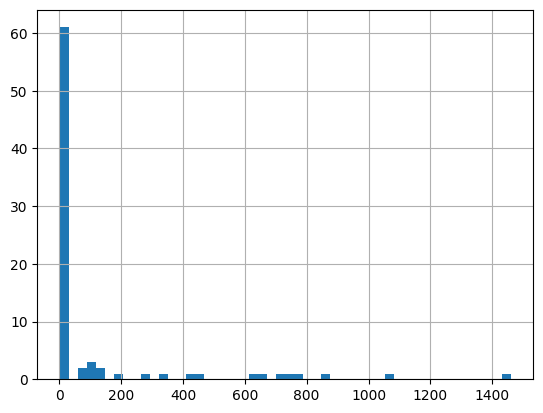

In [37]:
feat_categorical_nunique.hist(bins=50)

💡 As a starter, what about simply **removing** all features that have **7 unique values or more**, and one-hot-encode every other? Let's keep ordinal encoding and statistical feature selection for the next iteration of our pipeline.

❓ Store features names to OHE in a list `feat_categorical_small` below. How many features will be OHE?

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

🧪 Test your code below (and clear the cell once it passed)

In [ ]:
from nbresult import ChallengeResult
result = ChallengeResult('features_overview',
    n=len(feat_categorical_small))
result.write(); print(result.check())

### 1.2 Baseline pipe

#### a) Preprocessing

❓ Let's code the basic preprocessing pipeline described below. Save it under `preproc_baseline`.

For categorical features
- Simple-Impute with most frequent values
- One-Hot-Encode features that have less than 7 unique values to start with
- Drop all others features


As for numerical features
- Simple-Impute with strategy 'mean'
- Min-Max Scale 


<details>
    <summary>ℹ️ Click here for a pro tip</summary>

If you are confident, you can try sklearn's shorter syntax `make_pipeline` or `make_column_transformer` instead of the longer syntax `Pipeline` or `ColumnTransformer` if you want to avoid giving names manually to every steps.
</details>

In [ ]:
# YOUR CODE HERE

❓ Look at the **shape** of your preprocessed dataframe and save it to `shape_preproc_baseline` variable

In [ ]:
# YOUR CODE HERE

🧪 Test your code below

In [ ]:
from nbresult import ChallengeResult
result = ChallengeResult('preproc_baseline',
    shape=shape_preproc_baseline)
result.write()
print(result.check())

#### b) Add estimator

❓ Add a simple Decision Tree model to your `preproc_baseline` and store it to `pipe_baseline` variable.

In [ ]:
# YOUR CODE HERE

#### c) Cross-Validate

❓ Read the Kaggle [contest evaluation rules](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation) 
- Which performance metric do you need? Is it readily available in sklearn?
- We will need to create our custom `sklearn.metrics.scorer` object so as to pass to any cross-validation or grid search as below


👉 Create a scorer called `rmsle` using [`make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) that can be passed as a value for the `scoring` kwarg as below:
```python
cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle)
```
👉 Create also the negative version `rmsle_neg` which is best when _maximized_. This will come handy later as `GridSearchCV` always tries to _maximize_ a score
```python
GridSearchCV(pipe_baseline, param_grid=..., cv=5, scoring=rmsle_neg)
```

$$\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (\log_e (1 + y_i) - \log_e (1 + \hat{y}_i) )^2.}$$

In [ ]:
# YOUR CODE HERE

❓5-fold cross-validate your `pipe_baseline` using this metric to get a first glance at your baseline performance.    

Store your mean score as `score_baseline`

In [ ]:
# YOUR CODE HERE

#### d) Predict baseline

❓ Predict `y_pred_baseline` from the Kaggle `test.csv` dataset you stored in the `data` folder.

In [ ]:
# YOUR CODE HERE

❓ Finally, store your CSV ready to be submitted as `submission_baseline.csv` in the `data` folder. **Carefully read** the Kaggle required format and test it below (you don't need to submit this baseline online for now).

In [ ]:
# YOUR CODE HERE

🧪 Test your code

In [ ]:
from nbresult import ChallengeResult
tmp = pd.read_csv("data/submission_baseline.csv")
result = ChallengeResult('submission_baseline',
    score_baseline = score_baseline,
    submission_shape = tmp.shape,
    submission_columns = list(tmp.columns),
    submission_dtypes = str(list(tmp.dtypes)),
)
result.write()
print(result.check())

## 🏋️‍♀️ 2. ITERATIONS 

🎉 🎉 Congratulation for having fully pipelined a baseline model! You will see now how much easier it is to iterate and improve performance 🚀

- Your goal is to improve your prediction and submit it online **at least 30 minutes before the Recap ⏳**
- We have some suggestions for improvements below: **Pick your battles** and **incrementally** improve your pipeline as you see fit

**Estimators**

- **Tree-based ensembles (must try today)**: Probably the best suited for problems with many categorical features
- Stacking !
- XGBoost !

**Preprocessing** (once your first ensemble model works)

- Ordinal Encoding of categorical features with a hidden notion of order in their values (e.g. "bad", "average", good")
- Statistical Feature Selection to remove useless features (avoid overfitting and reduce train time)
- Predict `log(SalePrice)` instead?
- ...

### 2.1 Preprocessing Iteration ♲ 
(**⚠️ come back here only after you have iterated on your estimators on section 2.2)**

⏩ Collapse me if you don't use me!

#### a) Ordinal Encoding (1h)

❓ Look at the following feature below. Couldn't it be encoded numerically in a wise manner?
```
ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
```

💡 Luckily, the `OrdinalEncoder` and its argument `categories`  allows us to do just that. Check it out below and make sure to understand how this works

In [ ]:
# Define specific order for features
# Note: if you change this order, it will change the output for .transform()
feature_A_sorted_values = ['bad', 'average', 'good'] 
feature_B_sorted_values = ['dirty', 'clean', 'new']

encoder = OrdinalEncoder(
    categories=[
        feature_A_sorted_values,
        feature_B_sorted_values
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

# Just some random training data
XX = [
    ['good', 'dirty'],
    ['bad', 'new'],
    ['average', 'clean'],
]

encoder.fit(XX)

encoder.transform([
        ['bad', "dirty"],
        ["average", "clean"],
        ['good', 'new'],
        ['bad', 'oooops never seen this label before']
])

---
❓ **Your turn**: split your categorical preprocessor into

- `preproc_ordinal` to ordinally encode **some features** of your choice
- `preproc_nominal` to one-hot encode the other ones


<details>
    <summary>Hints</summary>

- You won't be able to avoid hard-coding names and ordered values of features! Be tidy!
- It's a good practice to sort alphabetically your features to avoid bad surprises
</details>

In [ ]:
# YOUR CODE HERE

#### b) Statistical Feature Selection (~30min)

Our goal is to remove the least interesting features, to limit overfitting and shorten training time.  

🔥 We will make use of sklearn's [feature selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) transformers directly in your pipeline!

❗️ We recommend you to **try only Option 1 today to start with**. Option 2 and 3 will be corrected in Recap

##### (Option 1 - recommended) <font color=green>Univariate</font> feature selection based on their mutual information with target `y`

- Feel free to add a `SelectPercentile` filter at the end of your `preproc` pipeline.
- This will filter-out features that, - taken individually - least explain your target!
- The statistical test we recommend to pass to SelectPercentile is the `mutual_info_regression`

<details>
    <summary markdown='span'>🤔 What is mutual information? Click here!</summary>

- Mutual information is a *statistical* distance between two probability distributions.
- Correlation is a *linear* distance between two random variables.
- Mutual information is more general and measures the reduction of uncertainty in Y after observing X.
- On the other hand, if you already know you are working with variables that are smooth (like continuous numerical variables), sometimes correlation may tell you more about them, for instance if their relationship is monotonic.

See [animation](https://twitter.com/ari_seff/status/1409296508634152964)
</details>

In [ ]:
# YOUR CODE HERE

##### (option 2) <font color=green>Multivariate</font> feature selection based their combined relationship with target `y`

🤔 We want to remove features that, when in combination with all the others, do not really help predict our target.

1️⃣ To do so, remember that we can use feature [`permutation_importance`](https://scikit-learn.org/stable/modules/permutation_importance.html) metric in combination with an estimator! It trains one pipe per feature, so as to estimate which feature makes our performance score *decrease* the most when shuffling it randomly. These would be our most important features, which we don't want to remove. 

The best thing is, scikit-learn allows you to integrate this methodology directly into your `preproc` pipeline thanks to the [`SequentialFeatureSelector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) transformer: this will recursively remove least important features according to the `cross_val_score`.

However, this process can take extremely long to train when you have many features.

2️⃣ Alternatively, a faster way would be to make use of models that already output some measure of feature_importance when fitting them. For instance, Trees with gini-based `feature_importance_`, or Lasso regressions with L1 `coef_`. Again here, scikit-learn already has the [`SelectFromModel`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) transformer to do just that.

In [ ]:
# YOUR CODE HERE

##### (option 3) <font color=green>Unsupervised</font> selection: Filter based only on the properties of `X`? 

❓ A quick win is to remove features with the lowest variance. Think about it: a feature which only has one value is useless (and has a variance of 0).  
- Feel free to add a [`VarianceThreshold`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html) to the end of your pipeline

In [ ]:
# YOUR CODE HERE

❓ Additionally, we can check for correlation between our **numerical features** only

- Use [Pearson's correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) combined with a heatmap to check visually whether some **numerical** features almost entirely correlate with others. 
- Use `VIF` from statsmodels to check for features that have the highest multicollinearity

In [ ]:
# YOUR CODE HERE

❓ For **ordinal features**, we can use [Spearman's rank correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) instead to check whether some **ordinally encoded** features are almost entirely "ordered" similarly to others. Feel free to plot a heatmap again

In [ ]:
# YOUR CODE HERE

❓ Now, feel free to create a "filter" in your pipeline that removes any feature you want beyond a given (Spearman + Pearson) correlation threshold. You'll need a custom transformer class

In [ ]:
# YOUR CODE HERE

#### e) Target engineering (15 min)

❓ We are asked to minimize the RMS**L**E. Why don't we transform our target to directly predict its `log`?
- Check out the histogram of the target `y`.
- Normally distributed variables should be easier to predict with linear or parametric models. 
- Create `y_log` and your new performance metrics
- Don't forget to take the exponent of your predictions at the end!

In [ ]:
# YOUR CODE HERE

### 2.2 Model Iteration ♻

#### a ) Final version of the preproc pipeline
❓ We advise you to start with a fresh definition below so you can quickly update it as need be.

In [ ]:
# YOUR CODE HERE

# 🏅FINAL SUBMISSION (submit at least 30 min before Recap)

Discover your real test score by submitting on Kaggle! 

👉 Write down your test score on the [result spreadsheet here](https://docs.google.com/spreadsheets/d/1ZEBKwa_k1Ytb0WCOh-Nopq3eaezwBNu1SAqKXEXRguc/edit#gid=0) (pick the correct batch!)

In [ ]:
# YOUR CODE HERE